# Generic Time-Series Anomaly Detection using Autoencoder

Embedded & TinyML Friendly Student Template

## Objective
This notebook demonstrates a generic anomaly detection approach for time-series sensor data using an autoencoder.

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

## Configuration (Edit Only This Section)

•	Tensors: Models operate using tensors, essentially lists or arrays of numbers. A 1D tensor is a vector, a 2D tensor is a matrix, and a single number is a scalar.

•	Feature Generation: Raw data, often collected as time series with inconsistent intervals, must be prepared for the model. A common technique is windowing, where a chunk of time is defined, and values within that window are combined (e.g., by averaging) to create a single set of input features.

•	Normalization: For the training algorithm to work effectively, feature values must be scaled, ideally into a similar range (like 0 to 1). For example, 8-bit image data (0-255) is normalized by multiplying values by 1/255.

## Load Sensor Data

In [7]:

normal_df = pd.read_csv("normal_data.csv")
abnormal_df = pd.read_csv("abnormal_data.csv")

print("Normal shape   :", normal_df.shape)
print("Abnormal shape :", abnormal_df.shape)

Normal shape   : (600, 3)
Abnormal shape : (600, 3)


Keeping only [current, vibration] data removing time column

In [8]:
normal_features = normal_df.drop(columns=['time'])
abnormal_features = abnormal_df.drop(columns=['time'])
#printing shape after dropping the 'time' column
print(normal_features.shape)
print(abnormal_features.shape)


(600, 2)
(600, 2)


Autoencoder is trained ONLY on normal data.

3️⃣ Feature Selection (VERY IMPORTANT)

Keep only numeric sensor features.

In [9]:
features = normal_features.columns.tolist()
print("Features used:", features)


Features used: ['Irms', 'VibrationMag']


Confirming Final Table Data

In [10]:
normal_features.head()

,Irms,VibrationMag
0,0.303685,0.036216
1,0.300606,0.056023
2,0.307243,0.069711
3,0.308459,0.075328
4,0.309300,0.048889


## Sliding Window Creation in not Required here as Anomalies cause instantaneous deviations, not slow wearout

## Normalization and Scalar Selection

This scaler must be reused later on STM32 logic (mean & std).

// Extracted from Python scaler
#define IRMS_MEAN        2.34f
#define IRMS_STD         0.15f
#define VIB_MEAN         0.012f
#define VIB_STD          0.003f

float irms = read_current_sensor();
float vib  = read_vibration_sensor();

// StandardScaler normalization
float irms_norm = (irms - IRMS_MEAN) / IRMS_STD;
float vib_norm  = (vib  - VIB_MEAN)  / VIB_STD;

// Fill AI input buffer
((float*)in_data)[0] = irms_norm;
((float*)in_data)[1] = vib_norm;

In [11]:
scaler = StandardScaler()

X_train = scaler.fit_transform(normal_features)
X_test_normal = scaler.transform(normal_features)
X_test_abnormal = scaler.transform(abnormal_features)

In [12]:
print("Scaler mean :", scaler.mean_)
print("Scaler std  :", scaler.scale_)

Scaler mean : [0.29274811 0.04952801]
Scaler std  : [0.0287444 0.0123394]


## Autoencoder Model

In [ ]:
#to Reset the model if trained with same data multiple times to avoid over fitting
#tf.keras.backend.clear_session()

In [14]:

N = X_train.shape[1]  # number of features (2)

autoencoder = models.Sequential([
    layers.Dense(8, activation='relu', input_shape=(N,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(N)
])

autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

autoencoder.summary()


c:\Users\z665059\OneDrive - ZF Friedrichshafen AG\Documents\my_project_temperature_classification\venv1\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

## Training only on Normal Data

In [15]:

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8580 - val_loss: 0.8316
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7954 - val_loss: 0.7708
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7375 - val_loss: 0.7150
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6785 - val_loss: 0.6604
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6222 - val_loss: 0.6074
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5695 - val_loss: 0.5581
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5199 - val_loss: 0.5104
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4743 - val_loss: 0.4649
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4288 - val_loss: 0.4207
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3887 - val_loss: 0.3768
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3491 - val_loss: 0.3402
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3160 - val

## Plot Training Loss

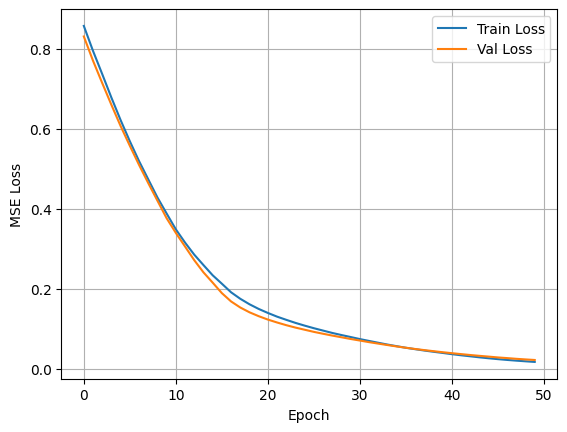

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()


## Reconstruction Error Function

In [17]:

def reconstruction_error(model, data):
    recon = model.predict(data)
    return np.mean(np.square(data - recon), axis=1)




On STM32, you will compute exactly the same thing:

error = mean((input[i] - output[i])²)


Then:

if (error > THRESHOLD)
    anomaly = 1;
else
    anomaly = 0;

## Compute Errors

In [18]:
err_normal = reconstruction_error(autoencoder, X_test_normal)
err_abnormal = reconstruction_error(autoencoder, X_test_abnormal)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


## Threshold Selection

In [19]:

threshold = np.mean(err_normal) + 3 * np.std(err_normal)
print("Anomaly Threshold:", threshold)


Anomaly Threshold: 0.21066869885202502


## Visualize Error Distribution (Very Important)

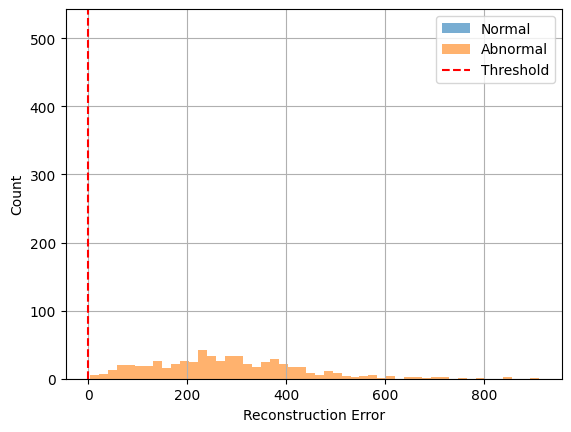

In [20]:
plt.hist(err_normal, bins=50, alpha=0.6, label="Normal")
plt.hist(err_abnormal, bins=50, alpha=0.6, label="Abnormal")
plt.axvline(threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()


## Binary Evaluation

In [21]:
y_true = np.concatenate([
    np.zeros(len(err_normal)),
    np.ones(len(err_abnormal))
])

y_pred = np.concatenate([
    err_normal > threshold,
    err_abnormal > threshold
]).astype(int)


## Confusion Metrics

In [22]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=["Normal", "Anomaly"]
))


Confusion Matrix:
[[590  10]
 [  0 600]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       600
     Anomaly       0.98      1.00      0.99       600

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



## Testing on New Data

In [23]:

sample = abnormal_features.iloc[0].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)

error = reconstruction_error(autoencoder, sample_scaled)[0]

print("Reconstruction Error:", error)

if error > threshold:
    print("⚠️ Anomaly detected")
else:
    print("✅ Normal operation")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Reconstruction Error: 5.904759140462705
⚠️ Anomaly detected


c:\Users\z665059\OneDrive - ZF Friedrichshafen AG\Documents\my_project_temperature_classification\venv1\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Convert to TFLITE


In [24]:
autoencoder.save("autoencoder_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("autoencoder_anomaly.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully")
print("Model size:", len(tflite_model), "bytes")


INFO:tensorflow:Assets written to: C:\Users\z665059\AppData\Local\Temp\tmp5wi5oheg\assets


INFO:tensorflow:Assets written to: C:\Users\z665059\AppData\Local\Temp\tmp5wi5oheg\assets


Saved artifact at 'C:\Users\z665059\AppData\Local\Temp\tmp5wi5oheg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2938611096784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611098704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611096208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611097552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611099280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611097744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611099664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2938611098512: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved successfully
Model size: 2728 bytes


Testing on new sensor collected data

In [ ]:
#extract data from csv (time column removed data)
new_features = pd.read_csv("new_data_normal.csv")
#scaling and noramlization same as the one used during training
X_new = scaler.transform(new_features)
#run autoencoder on new data
recon = autoencoder.predict(X_new)
#compute the reconstrction error
err_new = np.mean(np.square(X_new - recon), axis=1)
#Apply the Threshold (Decision Logic)
is_anomaly = err_new > threshold
#Inspect Results (Text Output)
results = new_features.copy()
results['reconstruction_error'] = err_new
results['anomaly'] = is_anomaly

print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
        Irms  VibrationMag  reconstruction_error  anomaly
0   0.472171      0.009430              7.187282     True
1   0.460262      0.035856              8.369301     True
2   0.427700      0.066795              8.353912     True
3   0.331956      0.321103             71.803304     True
4   0.326794      0.541074            234.365740     True
5   0.326522      0.507858            203.263061     True
6   0.331803      0.800647            556.215251     True
7   0.335726      0.771619            517.214909     True
8   0.341026      0.605437            309.874818     True
9   0.339294      0.886070            697.831233     True
10  0.341564      0.425921            142.945161     True
11  0.336578      0.522758            222.440257     True
12  0.337373      0.726306            455.599015     True
13  0.344251      0.855954            653.293714     True
14  0.344737      0.550727            254.347803     True
15  0.338791      0.400483        

Visualize New Data Errors (Highly Recommended)

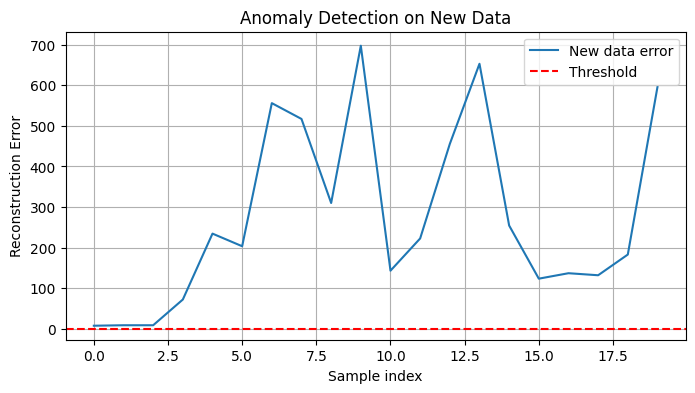

In [26]:
plt.figure(figsize=(8,4))
plt.plot(err_new, label="New data error")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.xlabel("Sample index")
plt.ylabel("Reconstruction Error")
plt.title("Anomaly Detection on New Data")
plt.legend()
plt.grid()
plt.show()


In [27]:
sample = new_features.iloc[0].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)
print(sample_scaled)
recon = autoencoder.predict(sample_scaled)
error = np.mean((sample_scaled - recon) ** 2)

print("Reconstruction error:", error)

if error > threshold:
    print("⚠️ Anomaly detected")
else:
    print("✅ Normal operation")


[[ 6.24199795 -3.24961035]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Reconstruction error: 7.187282390197027
⚠️ Anomaly detected


c:\Users\z665059\OneDrive - ZF Friedrichshafen AG\Documents\my_project_temperature_classification\venv1\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
